In [677]:
import os
os.chdir("/Users/davidamat/Documents/Projects/deepsetstats")
# os.chdir("/Users/davidamat/Documents/Personal/deepsetstats")

from deepsetstats.utils import utils_tools
from deepsetstats.utils import constants as c
from deepsetstats.utils import videocapture as vc
from deepsetstats.court_detection import edge_detection
from deepsetstats.utils import utils_viz as uv
from deepsetstats.utils import utils_colors as ucol
from deepsetstats.utils import utils_court as ucourt
from deepsetstats.utils import utils_dataclasses as udata


import cv2
from matplotlib import pyplot as plt
from pathlib import Path
import numpy as np
import copy
import torch
import colorsys
import time
import scipy.spatial as sp
from skimage.color import rgb2hsv, hsv2rgb
from matplotlib.colors import hsv_to_rgb, rgb_to_hsv
from scipy.spatial import distance_matrix

In [655]:
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = 1000
pd.options.display.width=None

In [656]:
%matplotlib inline
from importlib import reload
np.set_printoptions(threshold=2000)

In [1204]:
from importlib import reload
def rel():
    global utils_tools
    global c
    global vc
    global edge_detection
    global ucol
    global uv
    global ucourt
    global udata
    
    utils_tools = reload(utils_tools)
    udata = reload(udata)
    c = reload(c)
    vc = reload(vc)
    edge_detection = reload(edge_detection)
    ucol = reload(ucol)
    uv = reload(uv)
    ucourt = reload(ucourt)

In [1205]:
# Constants
rel()

Vis = uv.Visualizer()
Colors = ucol.Colors()
Court = ucourt.Court()

# 1. Load Videos and Dictionary of vids

In [782]:
# Dictionary of vids
extension = ".mp4"
gs = ["wb", "rg", "ao", "us"]

#c.PATH_VIDS = "/Users/davidamat/Documents/BackUp/DeepSetStats"
d_path_vids = {vid: str(Path(c.PATH_VIDS) / (vid + extension)) for vid in gs }
VC = vc.VideoClass(d_path_vids["rg"])
d_vc = { grandslam: vc.VideoClass(d_path_vids[grandslam]) for grandslam in gs}

# 2. Load frames

In [783]:
l_frames = [29*25, 29*25, 29*25, 25*25]
# in Color
d_f = {
   grandslam: d_vc[grandslam].get_frame(frame_num) for grandslam, frame_num in zip(gs, l_frames)
}

# In Black and White
d_fg = {
   grandslam: d_vc[grandslam]._correct_color(d_f[grandslam], gray=True) for grandslam in gs
}

# 3. Court

In [1296]:
%%time
tourn = "ao"

frameg = d_fg[tourn].copy()
frame = d_f[tourn].copy()
frame_lab = Colors.frame2lab(frame)
court_type, lab_court = Court.get_court_type(frame_lab)
print(f"Court type: {court_type}")

Court type: GREENSET_AO
CPU times: user 6.41 ms, sys: 15.6 ms, total: 22 ms
Wall time: 29.4 ms


### Histogram dominant colors

In [1297]:
%%time
cfg_hist = udata.ConfigHist
Colors.get_lab_histogram(frame_lab, cfg_hist, court_type)

CPU times: user 3.08 ms, sys: 4.61 ms, total: 7.69 ms
Wall time: 14.2 ms


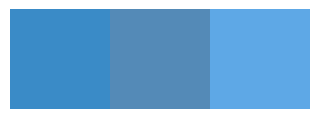

In [1298]:
Vis.show_lab(cfg_hist.top_lab)

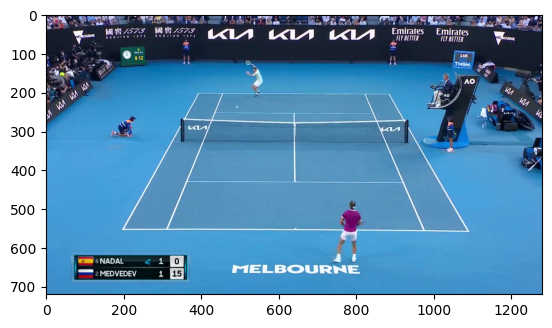

In [1299]:
VC.show_frame_lab(frame_lab)

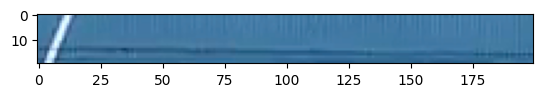

In [1300]:
VC.show_frame_lab(frame_lab[310:330,400:600])

## 3.1 Edge detect

In [1301]:
%%time
ED = edge_detection.EdgeDetect(th=20 if tourn == "rg" else 30)

# Detect changes of luminosity
mask_edges = ED.img2edges(frame_lab[:,:,0])

CPU times: user 81.9 ms, sys: 51 ms, total: 133 ms
Wall time: 142 ms


### Create grid

In [1302]:
cfg_grid = udata.ConfigGrid(frame)

In [1303]:
%%time
# Grid 1
x_vlines, y_hlines, cfg_grid.x_diff, cfg_grid.y_diff = ED.create_grid(cfg_grid.slices_xy, cfg_grid.marg_xy, cfg_grid.frame_shape_hw)
cfg_grid.xx, cfg_grid.yy = np.meshgrid(x_vlines, y_hlines)

# Grid 2: Shifted
x_vlines2, y_hlines2, _, _ = ED.create_grid(cfg_grid.slices_xy, cfg_grid.marg_xy, cfg_grid.frame_shape_hw, shifted=True)
cfg_grid.xx2, cfg_grid.yy2 = np.meshgrid(x_vlines2, y_hlines2)

CPU times: user 406 µs, sys: 133 µs, total: 539 µs
Wall time: 472 µs


### Correct mask

In [1304]:
%%time
mask_edges_corrected = ED.get_corrected_mask(frame_lab, mask_edges, court_type, cfg_hist, cfg_grid)

CPU times: user 24.1 ms, sys: 2.05 ms, total: 26.1 ms
Wall time: 25.3 ms


### Line Coordinate Logic

In [1305]:
%%time
edge_detection = reload(edge_detection)
ED = edge_detection.EdgeDetect(th=20 if tourn == "rg" else 30)

CPU times: user 1.55 ms, sys: 1.95 ms, total: 3.5 ms
Wall time: 3.7 ms


In [1306]:
%%time
l_dicts_xy = [
    ED.get_coordinates_lines(mask_edges_corrected, x_vlines, is_vertical=True),
    ED.get_coordinates_lines(mask_edges_corrected, y_hlines, is_vertical=False),
    ED.get_coordinates_lines(mask_edges_corrected, x_vlines2, is_vertical=True),
    ED.get_coordinates_lines(mask_edges_corrected, y_hlines2, is_vertical=False)
]
l_xy_lines = ED.collect_xy_lines(l_dicts_xy)

CPU times: user 8.41 ms, sys: 1.77 ms, total: 10.2 ms
Wall time: 8.94 ms


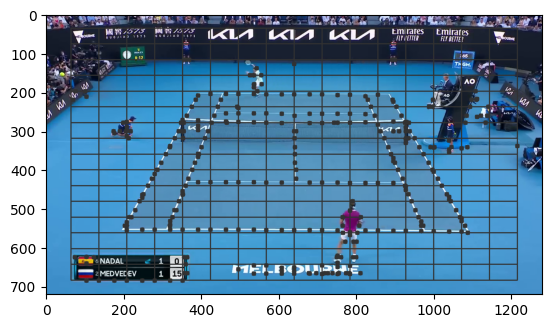

In [1307]:
# Show grid and points predicted as lines
plot_frame = frame.copy()
plot_frame = Vis.draw_line_points(plot_frame, l_xy_lines)
#VC.show_frame(plot_frame)
Vis.visualize_grid(plot_frame, x_vlines, y_hlines, color_grid=(50,50,50))

### Impose Line color to be white

In [1308]:
%%time
rgb_white_lines = np.vstack((
    c.D_GRAD_LINES[court_type]["LINE_CLEAN"],
    c.D_GRAD_LINES[court_type]["LINE_DIRTY"],
    c.RGB_LINE_WHITE))
lab_white_lines = Colors.frame2lab(rgb_white_lines)

CPU times: user 454 µs, sys: 123 µs, total: 577 µs
Wall time: 525 µs


In [1309]:
def create_surrounding(frame_lab, x, y, val=3):
    return np.array(frame_lab[y-val:y+val, x-val:x+val, :].reshape(-1,3), dtype=np.int16)

def any_close_white(frame_lab, x, y, arr_whites):
    surroundings_xy = create_surrounding(frame_lab, x, y)
    for color_white in arr_whites:
        color_diff_surround_whites = np.subtract(surroundings_xy, color_white)
        closest_distance_to_white_line = np.min(np.mean(np.abs(color_diff_surround_whites), axis=1))
        if closest_distance_to_white_line < 10:
            return True
    return False

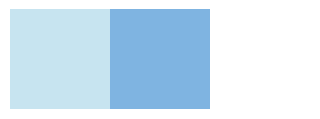

In [1310]:
Vis.show_lab(lab_white_lines)

In [1311]:
%%time
white_xy_points = []
arr_whites = np.array(lab_white_lines, dtype=np.int16)

for tup_xy in l_xy_lines:
    x,y = tup_xy
    if any_close_white(frame_lab, x, y, arr_whites):
        white_xy_points.append((x,y))

CPU times: user 13.9 ms, sys: 1.93 ms, total: 15.9 ms
Wall time: 14.8 ms


In [1312]:
plot_frame = frame_lab.copy()
plot_frame = Vis.draw_line_points(plot_frame, [(568, 578)])

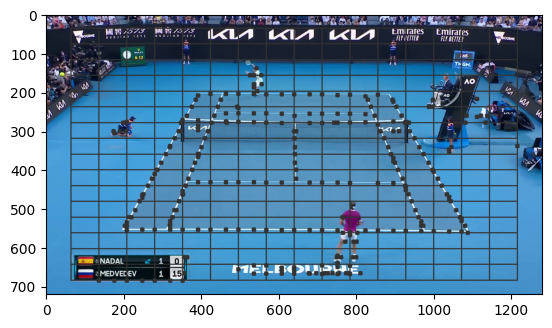

In [1313]:
# Show grid and points predicted as lines
plot_frame = frame.copy()
plot_frame = Vis.draw_line_points(plot_frame, white_xy_points)
#VC.show_frame(plot_frame)
Vis.visualize_grid(plot_frame, x_vlines, y_hlines, color_grid=(50,50,50))

### Visualize grid

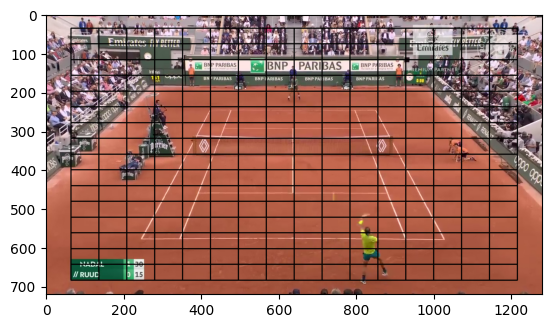

In [911]:
Vis.visualize_grid(frame, x_vlines, y_hlines)

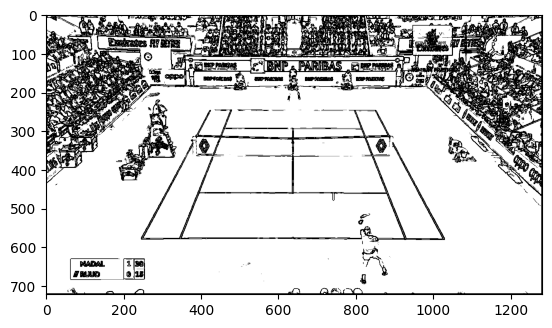

In [912]:
VC.show_gray(mask_edges)

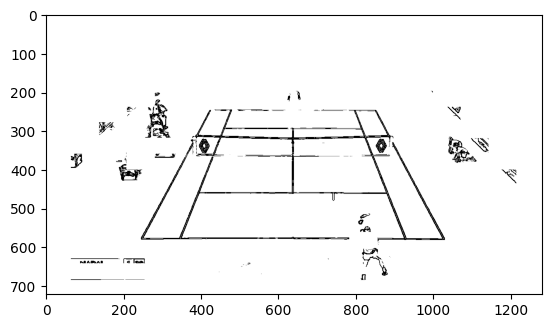

In [913]:
VC.show_gray(mask_edges_corrected)

In [830]:
mask_edges_corrected[600:650,700:701].ravel()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=uint8)

In [170]:
y_diff

40

In [171]:
frame_crop = frame.copy()
for row in range(rows):
    for col in range(cols):
        xv = xx[row][col]
        yv = yy[row][col]
        crop = frame_crop[yv:yv + y_diff, xv:xv + x_diff]
        break
    break

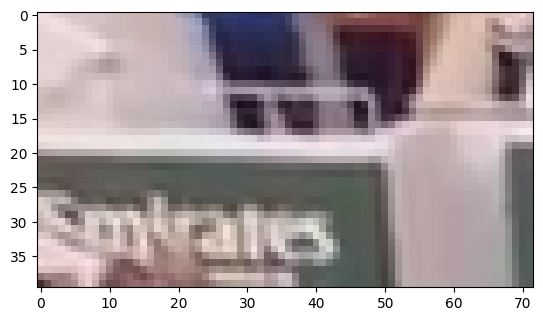

In [173]:
VC.show_frame(crop)

In [ ]:
def iterate_grid()